## 7. Queuing Model (90 pts)

In [3]:
%load_ext autoreload
%autoreload 2

from queries import query_mw as q_mw
from queries import query_client as q_client

from plots.ctrl import generate, dashboard_nc, dashboard_time
from plots import tp, rt

suite={
    "exp41":"simulation_p2",
    "exp41ext":"simulation_p2"
}

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [7]:
exp_name="exp41"
df_exp41_mw = q_mw.load_df(suite=suite[exp_name], exp=exp_name)
df_exp41_client = q_client.load_df(suite=suite[exp_name], exp=exp_name)

Client: 0 repetitions don't have throughput


arrival rate: 2356, service_rate: 399.0625   m:16.0
arrival rate: 2356, service_rate: 399.0625   m:16.0
arrival rate: 2367, service_rate: 259.78125   m:32.0
arrival rate: 2396, service_rate: 164.225   m:64.0
arrival rate: 2405, service_rate: 92.6625   m:128.0
arrival rate: 4519, service_rate: 399.0625   m:16.0
arrival rate: 4334, service_rate: 259.78125   m:32.0
arrival rate: 4455, service_rate: 164.225   m:64.0
arrival rate: 4312, service_rate: 92.6625   m:128.0
arrival rate: 5562, service_rate: 399.0625   m:16.0
arrival rate: 5699, service_rate: 259.78125   m:32.0
arrival rate: 5707, service_rate: 164.225   m:64.0
arrival rate: 5737, service_rate: 92.6625   m:128.0
arrival rate: 6262, service_rate: 399.0625   m:16.0
arrival rate: 7663, service_rate: 259.78125   m:32.0
arrival rate: 7975, service_rate: 164.225   m:64.0
arrival rate: 8027, service_rate: 92.6625   m:128.0
arrival rate: 6243, service_rate: 399.0625   m:16.0
arrival rate: 8102, service_rate: 259.78125   m:32.0
arrival rat

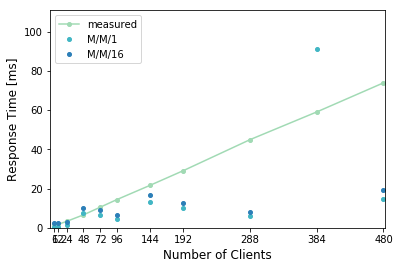

Worker: 16


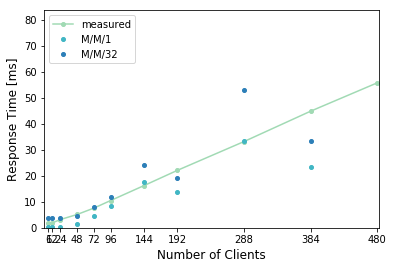

Worker: 32


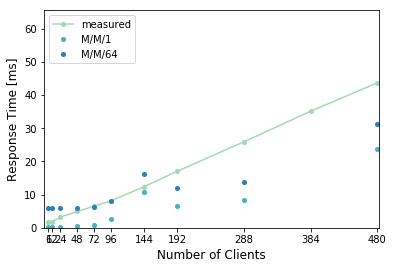

Worker: 64


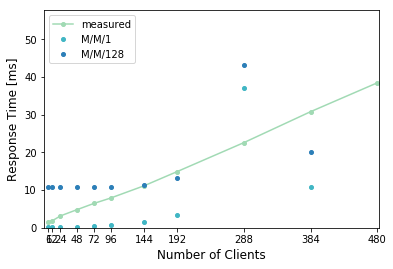

In [33]:
import pandas as pd

import oct2py

oc = oct2py.Oct2Py()

oc.eval("pkg load queueing")

def _mm1(arrival_rate, service_rate):
    utilization, rt, n_jobs_system, tp, p0 = oc.eval(f"qsmm1({arrival_rate}, {service_rate})",nout=5)
    
    traffic_intensity = utilization
    n_jobs_queue = traffic_intensity / (1-traffic_intensity)
    busy_period = 1 / (service_rate*(1-traffic_intensity))
    
    return utilization, rt*1000, n_jobs_system, tp, p0, n_jobs_queue, busy_period*1000

def _mmm(arrival_rate, service_rate, m):
    print(f"arrival rate: {arrival_rate}, service_rate: {service_rate}   m:{m}")

    utilization_per_server, rt, n_jobs_system, tp, p0, p_queueing = oc.eval(f"qsmmm({arrival_rate}, {service_rate}, {m})",nout=6)
        
    traffic_intensity = utilization_per_server
    n_jobs_queue = traffic_intensity * p_queueing / (1-traffic_intensity)
    n_jobs_service = m * traffic_intensity
    
    return utilization_per_server, rt*1000, n_jobs_system, tp, p0, p_queueing, n_jobs_queue, n_jobs_service


    


df = df_exp41_mw[['n_worker_per_mw', 'num_clients', 'arrivalrate_rep_mean', 'throughput_rep_mean', 'rt_rep_mean', 'qwt_rep_mean', 
                  'wtt_rep_mean', 'sst_rep_mean', 'queue_rep_mean']]

df = df.rename(index=str, columns={'arrivalrate_rep_mean': 'arrival_rate', 
                                        'throughput_rep_mean': 'meas_tp',
                                        'rt_rep_mean': 'meas_rt',
                                        'qwt_rep_mean':'meas_qwt',
                                        'wtt_rep_mean':'meas_wtt',
                                        'sst_rep_mean':'meas_sst',
                                        'queue_rep_mean':'meas_n_jobs_in_queue'
                                  })

#display(df[df['n_worker_per_mw']==8])

#display(df[df['n_worker_per_mw']==16])

#display(df[df['n_worker_per_mw']==32])

#display(df[df['n_worker_per_mw']==64])

# arrival rate for both the same -> measured with new possibility (arrival)

# service rate different for different number of workers but constant over different number of clients
# for M/M/1 use maximal throughput with given number of workers
# for M/M/m use maximal throughput with given number of workers divided by 2*n_workers
# m = 2 * n_workers 

mm1_service_rate = {
    8 : 6385+10,
    16: 8313+10,
    32: 10504+10,
    64: 11848+10
}

mmm_service_rate = {
    8 : 6385/(8*2),
    16: 8313/(16*2),
    32: 10504/(32*2) + 0.1,
    64: 11848/(64*2) + 0.1
}

df[['mm1_utilization', 'mm1_rt', 'mm1_n_jobs_system', 'mm1_tp', 'mm1_p0', 'mm1_n_jobs_queue', 'mm1_busy_period']] = df.apply(lambda row: pd.Series(_mm1(int(row['arrival_rate']), mm1_service_rate[row['n_worker_per_mw']])), axis=1)

#df = df[df['n_worker_per_mw']<32] # TODO remove
#display(df)
df[['mmm_utilization_per_server', 'mmm_rt', 'mmm_n_jobs_system', 'mmm_tp', 'mmm_p0', 'mmm_queueing','mmm_n_jobs_queue', 'mm1_jobs_service']] = df.apply(lambda row: pd.Series(_mmm(int(row["arrival_rate"]), mmm_service_rate[row['n_worker_per_mw']], m = 2*row['n_worker_per_mw'])), axis=1)

df['est_service_time'] = df.apply(lambda row: row['meas_rt']-row['meas_qwt'], axis=1)
df['est_service_rate'] = df.apply(lambda row: 2 * row['n_worker_per_mw'] * 1000/row['est_service_time'], axis=1)
    



for n_worker in df['n_worker_per_mw'].unique():
    dfw = df[df['n_worker_per_mw']==n_worker]
    print(f"Worker: {n_worker}")
    generate(rt.queueing_model, dfw)

### 7.1 M/M/1

### 7.2 M/M/m

### 7.3 Network of Queues

### Book Examples

In [ ]:
m = 5
arrival_rate = 1/6
service_rate = 1/20

print(f"M/M/{m}")
U, R, Q, X, p0, pm = oc.eval(f"qsmmm({arrival_rate}, {service_rate}, {m})",nout=6)

print(f"Utilization = Traffic Intensity p = {U}")
print(f"Mean Response Time = {R}")
print(f"Mean number of jobs in system = {Q}")
print(f"Throughput= {X} (should be arrival rate in ergodic system)")
print(f"Probability of empty system = {p0}")
print(f"Probability of queuing = {pm}")

print("\nM/M/1")
arrival_rate = 125
service_rate = 500
U, R, Q, X, p0 = oc.eval(f"qsmm1({arrival_rate}, {service_rate})",nout=5)
print(f"Utilization = Traffic Intensity p = {U}")
print(f"Mean Response Time = {R}")
print(f"Mean number of jobs in system = {Q}")
print(f"Throughput= {X} (should be arrival rate in ergodic system)")
print(f"Probability of empty system = {p0}")